In [ ]:
import sys
sys.path.append("/Users/sandesh/repos/bdg-nanowire/nanowire_model/")
import imp

import physics
imp.reload(physics)

In [ ]:
my_physics = {}
my_physics['t0'] = 2
my_physics['N_D'] = 10

In [ ]:
np.array([phy.H[x,:,y,:].flatten() for x in range(phy.H.shape[0]) for y in range(phy.H.shape[2])]).flatten().reshape(20,20)

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


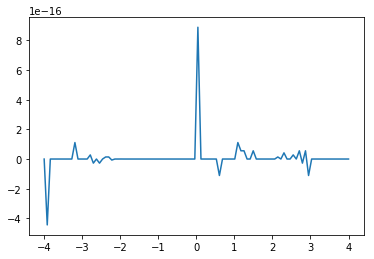

In [21]:
# Trying out the functional calculation of the Hamiltonian
import numpy as np
import itertools

t = 1.0
# 0+ to calculate Green's functions
eta = 1e-8

def create_Hamiltonian(N_lat,N_z):
   
    N = N_lat*N_lat*N_z


    # Hamiltonian element functions
    def create_alpha(ind):
        alpha = np.array([[2*t,0],[0,-2*t]])
        return alpha

    def create_beta(ind1,ind2):
        beta = np.array([[t,0],[0,-t]])
        return beta

    def create_zero():
        return np.zeros((2,2))

    def func_H(ind1,ind2):
        if ind1 == ind2:
            return create_alpha(ind1)
        elif tuple(abs(x) for x in tuple(i-j for i,j in zip(ind1,ind2))) \
        in [(0,0,1),(0,1,0),(1,0,0)]:
            return create_beta(ind1,ind2)
        else:
            return create_zero()

    # list of space indices of the Hamiltonian    
    indices = list(itertools.product(range(N_lat),range(N_lat),range(N_z)))
    H = [func_H(ind1,ind2) for ind1,ind2 in itertools.product(indices, indices)]

    H_ar = np.array(H,dtype=np.complex64).reshape((N,N,2,2))
    H_mat = np.array([H_ar[x,:,y,:].flatten() for x in range(H_ar.shape[0]) for y in range(H_ar.shape[2])]).flatten().reshape(2*N,2*N)

    return H_mat

def surface_g(E,N_lat):
    H_mat = create_Hamiltonian(N_lat,2)
    N = N_lat*N_lat
    alpha = H_mat[:2*N,:2*N]
    beta = H_mat[:2*N:,2*N:]
    
    err = 1.0
    iter_count = 0
    iter_limit = 10000
    err_limit = 1e-4

    g = np.eye(alpha.shape[0],dtype=np.complex64)
    g_old = np.eye(alpha.shape[0],dtype=np.complex64)
    # iterate over iter_limit iterations or until err < err_limit
    for i in range(iter_limit):
        g = np.linalg.inv((E + 1j*eta)*np.eye(alpha.shape[0]) - alpha - np.dot(np.dot(beta,g),beta))
        g = 0.5*(g + g_old)
        
        err = np.linalg.norm(g-g_old)/np.sqrt(np.linalg.norm(g)*np.linalg.norm(g_old))
        g_old = g
        if(err < err_limit):
            #print("Finished at",i)
            break;
        if(i == (iter_limit - 1)):
            print("iter_limit hit in calculation of surface_g")
    return g

def fermi(E,kT):
    return 1.0/(1.0 + np.exp(E/kT))

def current_E(E,N_lat,N):
    H_mat = create_Hamiltonian(N_lat, N)
    
    #print("H_mat",H_mat)
    #number of dof in a layer
    N_dof_lat = N_lat*N_lat*2
    # the hopping element between layers
    beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]
    
    g = surface_g(E,N_lat)
    # the only non-zero elements in sigma
    sigma_mini = np.dot(np.dot(beta_layer,g),beta_layer)
    
    sigma_1 = np.zeros(H_mat.shape,dtype=np.complex64)
    sigma_1[:N_dof_lat,:N_dof_lat] = sigma_mini
    gamma_1 = 1j*(sigma_1 - np.conj(sigma_1).T)
    
    sigma_2 = np.zeros(H_mat.shape,dtype=np.complex64)
    sigma_2[-N_dof_lat:,-N_dof_lat:] = sigma_mini
    gamma_2 = 1j*(sigma_2 - np.conj(sigma_2).T)    
    
    #print("sigma_1",sigma_1)
    #print("sigma_2",sigma_2)
    
    F1 = np.kron(np.eye(N_lat*N_lat*N_z),[[fermi(E - mu1,kT),0],[0,fermi(E + mu1,kT)]])
    F2 = np.kron(np.eye(N_lat*N_lat*N_z),[[fermi(E - mu2,kT),0],[0,fermi(E + mu2,kT)]])
    
    sigma_in = np.dot(gamma_1,F1) + np.dot(gamma_2,F2)
    #print("sigma_in",sigma_in)

    G = np.linalg.inv((E + 1j*eta)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2)
    
    A = 1j*(G - np.conj(G).T)
    
    G_n = np.dot(np.dot(G,sigma_in),np.conj(G).T)
    
    I_mat = np.dot(beta_layer,G_n[:N_dof_lat,N_dof_lat:2*N_dof_lat]) \
            - np.dot(G_n[N_dof_lat:2*N_dof_lat,:N_dof_lat],beta_layer)
    I = np.trace(I_mat[0:N_dof_lat,0:N_dof_lat])

    return I

mu1 = 2
mu2 = 3
N_lat = 1
kT = 1e-2

N_z = 3

E_linspace = np.linspace(-4,4,100)
I = [current_E(E,N_lat,N_z) for E in E_linspace]

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(E_linspace,I)

In [ ]:
%timeit surface_g(np.random.rand(1)[0],10)

In [ ]:
np.random.rand(1)[0]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

u,v = np.linalg.eig(H_mat)
kx = np.linspace(-np.pi,np.pi,2*N)
kxx,kyy = np.meshgrid(kx,kx)
E_exp = 2*t*(1 - np.cos(kxx) - np.cos(kyy))
E_exp = np.sort(E_exp.flatten())

plt.plot(kx,np.sort(u))


In [ ]:
E_exp = 2*t*(1 - np.cos(kx) - np.cos(kx[:,np.newaxis]))

In [ ]:
print("finished at %d th".(20))

In [ ]:
np.conj(H_mat).T

In [ ]:
a = np.array([[1,2+1j],[3,4]])
print(np.conj(a).T)

In [ ]:
np.kron(np.eye(3),[[1,1],[1,1]])